# Notebook for visualizing the results of a stylegan3 training


In [101]:
import os, json

results_dir = "training-runs/OITAVEN_TRAIN"
experiment_name = "00005-stylegan3-t-oitaven_train-gpus2-batch64-gamma0.125"

file_name = "stats.jsonl"
training_options_file_name = "training_options.json"

file_path = os.path.join(results_dir, experiment_name, file_name)
if not os.path.isfile(file_path):
    print(f"Error: The file {file_path} does not exist.")

# Labels for the classes
class_labels = range(10)

In [102]:
import numpy as np
import matplotlib.pyplot as plt

class_colors = {
    0: "#f4341c",
    1: "#744c14",
    2: "#bbbbbb",
    3: "#5c6474",
    4: "#fae53a",
    5: "#ec8c3c",
    6: "#93d664",
    7: "#52b450",
    8: "#76933f",
    9: "#036400",
}


def read_jsonl(file_path):
    """Reads a JSONL file and returns a list of parsed JSON objects."""
    with open(file_path, "r") as f:
        return [json.loads(line) for line in f]


def extract_metrics(jsonl_data, class_labels):
    """Extracts metrics from JSONL data into a dictionary of lists."""
    metric_keys = [
        "Loss/scores/fake",
        "Loss/signs/fake",
        "Loss/G/loss",
        "Loss/scores/real",
        "Loss/signs/real",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
        "Loss/D/loss",
        "Loss/r1_penalty",
        "Loss/D/reg",
        "Progress/tick",
        "Progress/kimg",
        "Timing/total_sec",
        "Timing/sec_per_tick",
        "Timing/sec_per_kimg",
        "Timing/maintenance_sec",
        "Resources/cpu_mem_gb",
        "Resources/peak_gpu_mem_gb",
        "Resources/peak_gpu_mem_reserved_gb",
        "Progress/augment",
        "Timing/total_hours",
        "Timing/total_days",
        "Timing/Gboth",
        "Timing/Dmain",
        "Timing/Dreg",
        "timestamp",
    ]
    metric_keys.extend([f"Accuracy/real/{c}" for c in class_labels])
    metric_keys.extend([f"Accuracy/fake/{c}" for c in class_labels])
    metric_keys.extend([f"Accuracy/val/{c}" for c in class_labels])
    metrics = {key: [] for key in metric_keys}

    for entry in jsonl_data:
        for key in metric_keys:
            value = entry.get(key, None)
            if isinstance(value, dict) and "mean" in value:
                metrics[key].append(value["mean"])
            else:
                metrics[key].append(value)
    return metrics


def _build_classification_keys(class_labels, data_type="real"):
    """Builds classification keys for the given class labels."""
    assert data_type in ["real", "fake", "val"]
    prefix = f"Accuracy/{data_type}"
    return [f"{prefix}/{c}" for c in class_labels]


def extract_classification_metrics(jsonl_data, class_labels):
    """Extracts classification metrics (mean and num) from the JSONL data into a dictionary."""
    classification_keys = (
        _build_classification_keys(class_labels, data_type="real")
        + _build_classification_keys(class_labels, data_type="fake")
        + _build_classification_keys(class_labels, data_type="val")
    )
    metrics = {key: {"mean": [], "num": []} for key in classification_keys}

    for entry in jsonl_data:
        for key in classification_keys:
            if key in entry:
                # Handle nested keys with "mean" and "num" values
                if isinstance(entry[key], dict):
                    metrics[key]["mean"].append(entry[key].get("mean", None))
                    metrics[key]["num"].append(entry[key].get("num", None))
                else:
                    metrics[key]["mean"].append(None)
                    metrics[key]["num"].append(None)
            else:
                metrics[key]["mean"].append(None)
                metrics[key]["num"].append(None)

    return metrics


def format_time(seconds):
    """
    Formats time in seconds into a human-readable format like '16h 20min 16s'.
    """
    hours, remainder = divmod(int(seconds), 3600)
    minutes, seconds = divmod(remainder, 60)
    formatted_time = []
    if hours > 0:
        formatted_time.append(f"{hours}h")
    if minutes > 0:
        formatted_time.append(f"{minutes}min")
    if seconds > 0 or not formatted_time:
        formatted_time.append(f"{seconds}s")
    return " ".join(formatted_time)


def summarize_training_stats(data, exclude_first_tick=True, display_hour_format=True):
    """
    Summarizes and displays training statistics, including total time, kimg, ticks,
    and mean/std of time per tick and per kimg.

    Args:
        data (dict): Dictionary containing training metrics.
        exclude_first_tick (bool): Whether to exclude the first tick from calculations.
        display_hour_format (bool): Whether to display total time in hh:mm:ss format.
    """
    first_index = 1 if exclude_first_tick else 0

    # Extract metrics
    total_kimg = data["Progress/kimg"][-1]
    total_ticks = data["Progress/tick"][-1]
    total_time_sec = data["Timing/total_sec"][-1]
    mean_sec_per_tick = np.mean(data["Timing/sec_per_tick"][first_index:])
    std_sec_per_tick = np.std(data["Timing/sec_per_tick"][first_index:])
    mean_sec_per_kimg = np.mean(data["Timing/sec_per_kimg"][first_index:])
    std_sec_per_kimg = np.std(data["Timing/sec_per_kimg"][first_index:])

    # Format total time
    if display_hour_format:
        total_time_formatted = format_time(total_time_sec)
        print(f"🕒 Total time: {total_time_formatted}")
    else:
        print(f"🕒 Total time: {total_time_sec:.2f} seconds")

    # Format time per tick
    mean_tick_time = format_time(mean_sec_per_tick)
    std_tick_time = format_time(std_sec_per_tick)

    # Format time per kimg
    mean_kimg_time = format_time(mean_sec_per_kimg)
    std_kimg_time = format_time(std_sec_per_kimg)

    # Display results
    print(f"📊 Total kimg: {round(total_kimg, 3)}")
    print(f"📈 Total ticks: {int(total_ticks)}")
    print(f"⏱️ Mean time per tick: {mean_tick_time} (std: {std_tick_time})")
    print(f"⏳ Mean time per kimg: {mean_kimg_time} (std: {std_kimg_time})")


def summarize_training_options(json_path):
    with open(json_path, "r") as f:
        config = json.load(f)

    # Extraer los valores relevantes
    class_weight = config.get("loss_kwargs", {}).get("class_weight")
    num_gpus = config.get("num_gpus")
    batch_size = config.get("batch_size")
    uniform_class_labels = config.get("uniform_class_labels")
    disc_on_gen = config.get("disc_on_gen")
    ada_target_present = "ada_target" in config
    ada_target_value = config.get("ada_target") if ada_target_present else None

    # Imprimirlos con emojis
    print("📋 Training Configuration Summary")
    print("────────────────────────────────────")
    print(f"⚖️  Class weight: {class_weight}")
    print(f"🖥️  Number of GPUs: {num_gpus}")
    print(f"📦 Batch size: {batch_size}")
    print(f"🎯 Uniform class labels: {uniform_class_labels}")
    print(f"🧪 Discriminator on generated images: {disc_on_gen}")
    if ada_target_present:
        print(f"🎛️  ADA target present ✅ → Value: {ada_target_value}")
    else:
        print("🎛️  ADA target present ❌")


def extract_confusion_matrix(jsonl_data, class_labels, progress_tick=None, data_type="real"):
    """Extracts confusion matrix data from JSONL data."""
    assert data_type in ["real", "fake", "val"]
    num_classes = len(class_labels)
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=int)
    entry = jsonl_data[-1] if progress_tick is None else jsonl_data[progress_tick]

    for real_class in class_labels:
        for pred_class in class_labels:
            key = f"Classification/{data_type}/{real_class}/{pred_class}"
            value = entry[key]
            if isinstance(value, dict) and "mean" in value and "num" in value:
                confusion_matrix[real_class, pred_class] = int(value["mean"] * value["num"])
    return confusion_matrix


def plot_confusion_matrix(confusion_matrix, class_labels):
    """Plots a confusion matrix with a heatmap and text annotations."""
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()

    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()


def plot_metric(data, metrics, x_axis="Progress/kimg", colors=None, marker="o", title=None, ylim=None):
    """Plots specific metrics against the x-axis."""
    plt.figure(figsize=(10, 5))
    for i, metric in enumerate(metrics):
        if metric in data:
            color = colors[i] if colors and i < len(colors) else None
            plt.plot(data[x_axis], data[metric], label=metric, color=color, marker=marker)
    plt.xlabel(x_axis)
    plt.ylabel("Metric Value")
    if ylim:
        plt.ylim(ylim)
    plt.title(title or f"{', '.join(metrics)} vs {x_axis}")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()


def print_accuracies_per_class(data, class_labels, last_ticks=10, data_type="val"):
    """
    Prints the accuracies for each class from the classification loss metrics.
    """
    classification_keys = _build_classification_keys(class_labels, data_type=data_type)
    accuracies = [data[metric][-last_ticks:] for metric in classification_keys]
    accuracies = np.array(accuracies)
    print(f"Last {last_ticks} accuracies per class ({data_type}):")
    for class_label, acc in zip(class_labels, accuracies):

        print(f"Class {class_label}: {[f'{a:.3f}' for a in acc]}")
    avg = np.mean(accuracies, axis=0)
    formatted = [f"{v:.3f}" for v in avg]
    print(f"Average accuracies over the last {last_ticks} ticks: {formatted}")


def compute_avg_accuracy(data, clean_nan, class_labels):
    """
    Computes the average accuracy from the classification loss metrics.
    """
    classification_keys = (
        _build_classification_keys(class_labels, data_type="real")
        + _build_classification_keys(class_labels, data_type="fake")
        + _build_classification_keys(class_labels, data_type="val")
    )
    accuracies_train = [data[metric] for metric in classification_keys if metric.startswith("Accuracy/real/")]
    accuracies_train_fake = [data[metric] for metric in classification_keys if metric.startswith("Accuracy/fake/")]
    accuracies_val = [data[metric] for metric in classification_keys if metric.startswith("Accuracy/val/")]
    if clean_nan:
        accuracies_train = [np.nan_to_num(acc, nan=0) for acc in accuracies_train]
        accuracies_train_fake = [np.nan_to_num(acc, nan=0) for acc in accuracies_train_fake]
        accuracies_val = [np.nan_to_num(acc, nan=0) for acc in accuracies_val]

    accuracies_train = np.array(accuracies_train)
    accuracies_train_fake = np.array(accuracies_train_fake)
    accuracies_val = np.array(accuracies_val)
    return (
        np.mean(accuracies_train, axis=0),
        np.std(accuracies_train, axis=0),
        np.mean(accuracies_train_fake, axis=0),
        np.std(accuracies_train_fake, axis=0),
        np.mean(accuracies_val, axis=0),
        np.std(accuracies_val, axis=0),
    )


def compute_overall_accuracy(classification_metrics):
    """
    Computes the overall accuracy from the classification metrics.
    """
    total_correct_train = None
    total_samples_train = None

    total_correct_val = None
    total_samples_val = None

    total_correct_train_fake = None
    total_samples_train_fake = None

    for key, values in classification_metrics.items():
        means = np.array(values["mean"])
        means = np.nan_to_num(means, nan=0.0)
        nums = np.array(values["num"])

        if key.startswith("Accuracy/val/"):
            if total_correct_val is None:
                total_correct_val = np.zeros_like(means)
                total_samples_val = np.zeros_like(nums)

            total_correct_val += means * nums
            total_samples_val += nums
        elif key.startswith("Accuracy/real/"):
            if total_correct_train is None:
                total_correct_train = np.zeros_like(means)
                total_samples_train = np.zeros_like(nums)

            total_correct_train += means * nums
            total_samples_train += nums
        else:
            if total_correct_train_fake is None:
                total_correct_train_fake = np.zeros_like(means)
                total_samples_train_fake = np.zeros_like(nums)

            total_correct_train_fake += means * nums
            total_samples_train_fake += nums

    return (
        total_correct_train / total_samples_train,
        total_correct_val / total_samples_val,
        total_correct_train_fake / total_samples_train_fake,
    )


def plot_accuracies(
    data, class_labels=range(10), plot_std_in_avg_accuracy=True, plot_type="both", dataset="both", include_fake=False
):
    """
    Plots the overall accuracy, average accuracy, or both over time.

    Args:
        data (dict): Dictionary containing the metrics data.
                     Should include keys like 'overall_accuracy_train' and/or 'overall_accuracy_val'
                     depending on the value of `dataset`.
        class_labels (list): List of class labels (default is range(10)).
        plot_std_in_avg_accuracy (bool): Whether to plot the standard deviation in the average accuracy plot.
        plot_type (str): Type of plot to generate. Options are:
                         - "overall": Plot only overall accuracy.
                         - "average": Plot only average accuracy.
                         - "both": Plot both overall and average accuracy in the same plot.
        dataset (str): Dataset to plot overall accuracy for: "train", "val", or "both". Default is "both".
        include_fake (bool): Whether to include fake data in the plots.
    """
    if plot_type not in ["overall", "average", "both"]:
        raise ValueError("Invalid plot_type. Choose from 'overall', 'average', or 'both'.")
    if dataset not in ["train", "val", "both"]:
        raise ValueError("Invalid dataset. Choose from 'train', 'val', or 'both'.")

    # Plot Overall Accuracy
    if plot_type in ["overall", "both"]:
        plt.figure(figsize=(10, 5))
        if dataset in ["train", "both"]:
            plt.plot(
                data["Progress/kimg"],
                data["overall_accuracy_train"],
                label="Overall Accuracy Train",
                marker="o",
                color="skyblue",
            )
            if include_fake and "overall_accuracy_train_fake" in data:
                plt.plot(
                    data["Progress/kimg"],
                    data["overall_accuracy_train_fake"],
                    label="Overall Accuracy Train Fake",
                    marker="^",
                    color="purple",
                )
        if dataset in ["val", "both"]:
            plt.plot(
                data["Progress/kimg"],
                data["overall_accuracy_val"],
                label="Overall Accuracy Val",
                marker="s",
                color="orange",
            )

        plt.xlabel("Progress/kimg")
        plt.ylabel("Overall Accuracy")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        if plot_type == "overall":
            plt.title(f"Overall Accuracy ({dataset.title()}) vs Progress/kimg")
            plt.show()

    # Compute Average Accuracy and Standard Deviation
    if plot_type in ["average", "both"]:
        (
            avg_accuracy_train,
            std_accuracy_train,
            avg_accuracy_train_fake,
            std_accuracy_train_fake,
            avg_accuracy_val,
            std_accuracy_val,
        ) = compute_avg_accuracy(data, clean_nan=True, class_labels=class_labels)

        if plot_type == "average":
            plt.figure(figsize=(10, 5))
        if dataset in ["train", "both"]:
            plt.plot(
                data["Progress/kimg"], avg_accuracy_train, label="Average Train Accuracy", marker="o", color="green"
            )
            if include_fake:
                plt.plot(
                    data["Progress/kimg"],
                    avg_accuracy_train_fake,
                    label="Average Train Fake Accuracy",
                    marker="^",
                    color="purple",
                )
        if dataset in ["val", "both"]:
            plt.plot(data["Progress/kimg"], avg_accuracy_val, label="Average Val Accuracy", marker="s", color="red")

        if plot_std_in_avg_accuracy:
            if dataset in ["train", "both"]:
                plt.fill_between(
                    data["Progress/kimg"],
                    avg_accuracy_train - std_accuracy_train,
                    avg_accuracy_train + std_accuracy_train,
                    alpha=0.2,
                    label="Standard Deviation Train",
                    color="green",
                )
                if include_fake:
                    plt.fill_between(
                        data["Progress/kimg"],
                        avg_accuracy_train_fake - std_accuracy_train_fake,
                        avg_accuracy_train_fake + std_accuracy_train_fake,
                        alpha=0.2,
                        label="Standard Deviation Train Fake",
                        color="purple",
                    )
            if dataset in ["val", "both"]:
                plt.fill_between(
                    data["Progress/kimg"],
                    avg_accuracy_val - std_accuracy_val,
                    avg_accuracy_val + std_accuracy_val,
                    alpha=0.2,
                    label="Standard Deviation Val",
                    color="red",
                )

        plt.xlabel("Progress/kimg")
        plt.ylabel("Average Accuracy")
        if plot_type == "average":
            plt.title("Average Accuracy vs Progress/kimg")
        else:
            plt.title("Overall and Average Accuracy vs Progress/kimg")
        plt.ylim(0, 1)
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    plt.close("all")


def plot_confusion_matrix(confusion_matrix, class_labels, title="Confusion Matrix"):
    """
    Plots a confusion matrix with a heatmap and text annotations.

    Args:
        confusion_matrix (np.ndarray): 2D NumPy array representing the confusion matrix.
        class_labels (list): List of class labels corresponding to the rows and columns of the matrix.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, interpolation="nearest", cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()

    # Add labels to the axes
    tick_marks = np.arange(len(class_labels))
    plt.xticks(tick_marks, class_labels, rotation=45)
    plt.yticks(tick_marks, class_labels)

    # Add text annotations in each cell
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(
                j,
                i,
                int(confusion_matrix[i, j]),
                horizontalalignment="center",
                color="white" if confusion_matrix[i, j] > confusion_matrix.max() / 2 else "black",
            )

    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.tight_layout()
    plt.show()


def print_tick_performance(metrics, tick):
    """
    Prints the performance summary for a specific tick.
    Args:
        metrics (dict): Dictionary containing the training metrics.
        tick (int): The tick index to summarize.
    """
    print("📊 Best Tick Performance Summary")
    print("────────────────────────────────────")
    print(f"⏱️  Tick: {int(metrics['Progress/tick'][tick])}")
    print(f"🖼️  kimg: {metrics['Progress/kimg'][tick]:.3f}")
    print(
        f"📈 Avg Accuracy (Train): {metrics['avg_accuracy_train'][tick]:.4f} ± {metrics['std_accuracy_train'][tick]:.4f}"
    )
    print(f"📊 Avg Accuracy (Val):   {metrics['avg_accuracy_val'][tick]:.4f} ± {metrics['std_accuracy_val'][tick]:.4f}")
    print(f"🏁 Overall Accuracy (Train): {metrics['overall_accuracy_train'][tick]:.4f}")
    print(f"✅ Overall Accuracy (Val):   {metrics['overall_accuracy_val'][tick]:.4f}")


def extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
):
    """
    Extracts the best tick performance based on the specified performance key.
    Args:
        metrics (dict): Dictionary containing the training metrics.
        performance_key (str): Key to determine the performance metric to use for finding the best tick.
                               Options are "avg" for average accuracy or "overall" for overall accuracy.
        verbose (bool): Whether to print the best tick performance summary.
    Returns:
        dict: A dictionary containing the best tick performance metrics.
    """
    assert performance_key in ["avg", "overall"]
    if only_tick_with_pkl or network_snapshot_ticks:
        assert (
            only_tick_with_pkl and network_snapshot_ticks is not None
        ), "only_tick_with_pkl must be True if network_snapshot_ticks is provided and vice versa."

    # Extract classification metrics and overall metrics
    classification_metrics = extract_classification_metrics(jsonl_data, class_labels)
    metrics = extract_metrics(jsonl_data, class_labels)

    # Compute overall accuracy
    metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
        compute_overall_accuracy(classification_metrics)
    )
    # Compute average accuracy and standard deviation
    (
        avg_accuracy_train,
        std_accuracy_train,
        avg_accuracy_train_fake,
        std_accuracy_train_fake,
        avg_accuracy_val,
        std_accuracy_val,
    ) = compute_avg_accuracy(metrics, clean_nan=True, class_labels=class_labels)
    metrics["avg_accuracy_train"] = avg_accuracy_train
    metrics["std_accuracy_train"] = std_accuracy_train
    metrics["avg_accuracy_train_fake"] = avg_accuracy_train_fake
    metrics["std_accuracy_train_fake"] = std_accuracy_train_fake
    metrics["avg_accuracy_val"] = avg_accuracy_val
    metrics["std_accuracy_val"] = std_accuracy_val

    if performance_key == "avg":
        accuracy_vals = avg_accuracy_val
    else:
        accuracy_vals = metrics["overall_accuracy_val"]

    if only_tick_with_pkl:
        best_tick = np.argmax(accuracy_vals[::network_snapshot_ticks]) * network_snapshot_ticks
    else:
        best_tick = np.argmax(accuracy_vals)

    if verbose:
        print_tick_performance(metrics, best_tick)

    best_tick_performance = dict(
        tick=metrics["Progress/tick"][best_tick],
        kimg=metrics["Progress/kimg"][best_tick],
        avg_accuracy_train=avg_accuracy_train[best_tick],
        std_accuracy_train=std_accuracy_train[best_tick],
        avg_accuracy_val=avg_accuracy_val[best_tick],
        std_accuracy_val=std_accuracy_val[best_tick],
        overall_accuracy_train=metrics["overall_accuracy_train"][best_tick],
        overall_accuracy_val=metrics["overall_accuracy_val"][best_tick],
    )

    return best_tick_performance

In [103]:
summarize_training_options(os.path.join(results_dir, experiment_name, training_options_file_name))

📋 Training Configuration Summary
────────────────────────────────────
⚖️  Class weight: 0.1
🖥️  Number of GPUs: 2
📦 Batch size: 64
🎯 Uniform class labels: True
🧪 Discriminator on generated images: True
🎛️  ADA target present ✅ → Value: 0.6


In [104]:
jsonl_data = read_jsonl(file_path)
metrics = extract_metrics(jsonl_data, class_labels=class_labels)
summarize_training_stats(metrics, exclude_first_tick=True)

🕒 Total time: 25h 11min 32s
📊 Total kimg: 1597.696
📈 Total ticks: 159
⏱️ Mean time per tick: 9min 20s (std: 55s)
⏳ Mean time per kimg: 55s (std: 5s)


In [105]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=False, network_snapshot_ticks=None
)

print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data,
    class_labels,
    performance_key="overall",
    verbose=True,
    only_tick_with_pkl=False,
    network_snapshot_ticks=None,
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 159
🖼️  kimg: 1597.696
📈 Avg Accuracy (Train): 0.9182 ± 0.0448
📊 Avg Accuracy (Val):   0.9305 ± 0.0862
🏁 Overall Accuracy (Train): 0.9331
✅ Overall Accuracy (Val):   0.9320

────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 132
🖼️  kimg: 1326.400
📈 Avg Accuracy (Train): 0.9306 ± 0.0321
📊 Avg Accuracy (Val):   0.9197 ± 0.0821
🏁 Overall Accuracy (Train): 0.9455
✅ Overall Accuracy (Val):   0.9366


In [106]:
print("────────────────────────────────────")
print("Using average accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="avg", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=5
)

print("\n────────────────────────────────────")
print("Using overall accuracy as performance key")
print("────────────────────────────────────")
best_tick_performance = extract_best_tick(
    jsonl_data, class_labels, performance_key="overall", verbose=True, only_tick_with_pkl=True, network_snapshot_ticks=5
)

────────────────────────────────────
Using average accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 70
🖼️  kimg: 703.424
📈 Avg Accuracy (Train): 0.8950 ± 0.0557
📊 Avg Accuracy (Val):   0.8980 ± 0.0683
🏁 Overall Accuracy (Train): 0.9257
✅ Overall Accuracy (Val):   0.8952

────────────────────────────────────
Using overall accuracy as performance key
────────────────────────────────────
📊 Best Tick Performance Summary
────────────────────────────────────
⏱️  Tick: 145
🖼️  kimg: 1457.024
📈 Avg Accuracy (Train): 0.9356 ± 0.0357
📊 Avg Accuracy (Val):   0.8953 ± 0.0765
🏁 Overall Accuracy (Train): 0.9529
✅ Overall Accuracy (Val):   0.9329


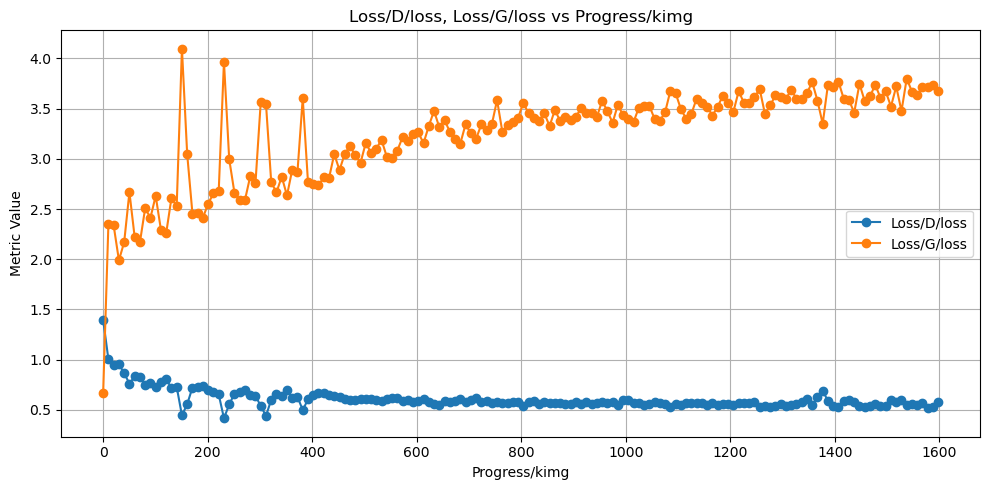

In [107]:
plot_metric(metrics, metrics=["Loss/D/loss", "Loss/G/loss"], x_axis="Progress/kimg")

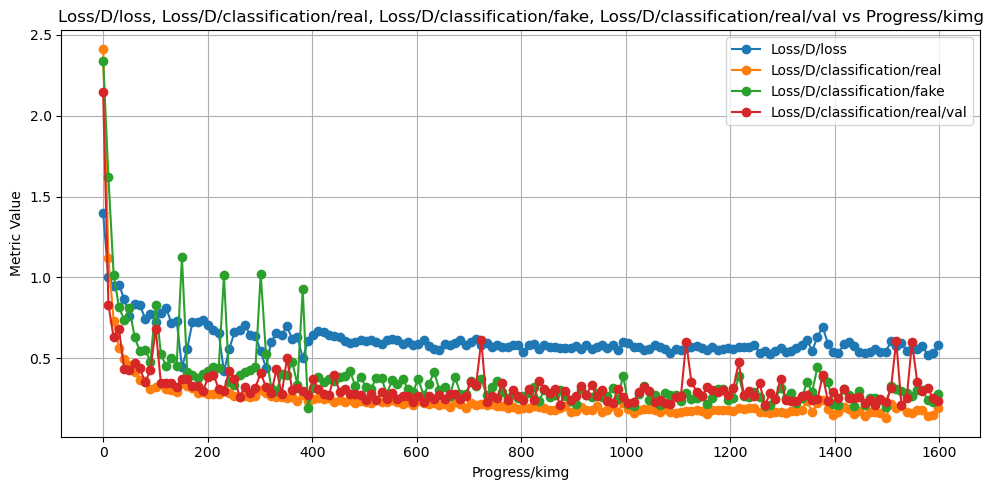

In [108]:
plot_metric(
    data=metrics,
    metrics=[
        "Loss/D/loss",
        "Loss/D/classification/real",
        "Loss/D/classification/fake",
        "Loss/D/classification/real/val",
    ],
    x_axis="Progress/kimg",
)

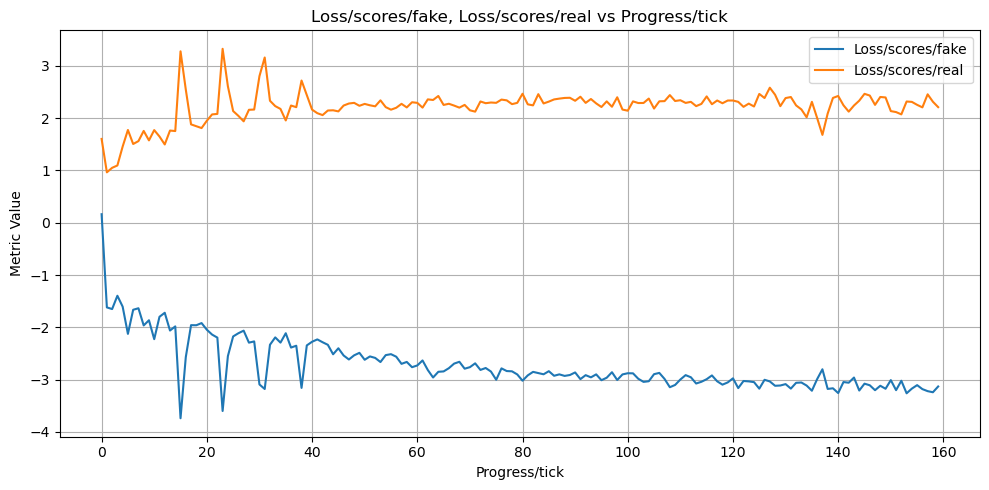

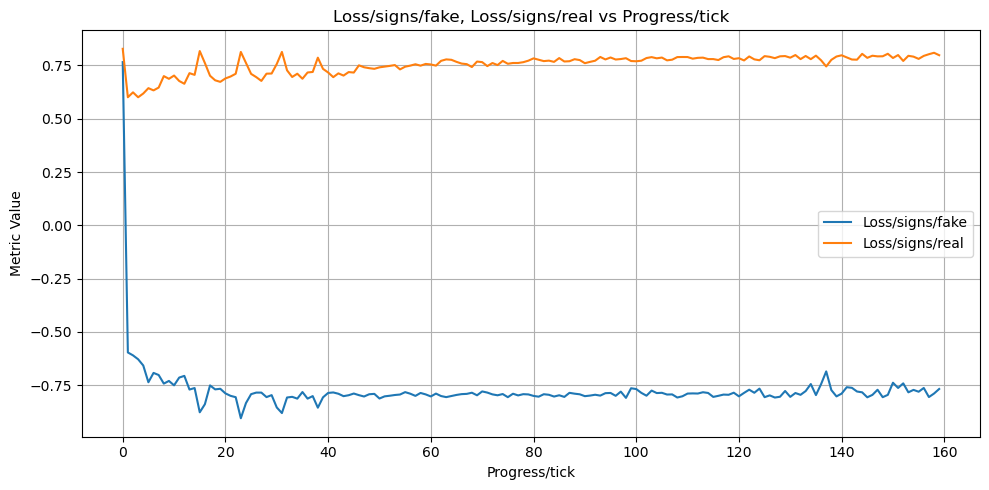

In [109]:
plot_metric(metrics, metrics=["Loss/scores/fake", "Loss/scores/real"], x_axis="Progress/tick", marker=None)
plot_metric(metrics, metrics=["Loss/signs/fake", "Loss/signs/real"], x_axis="Progress/tick", marker=None)

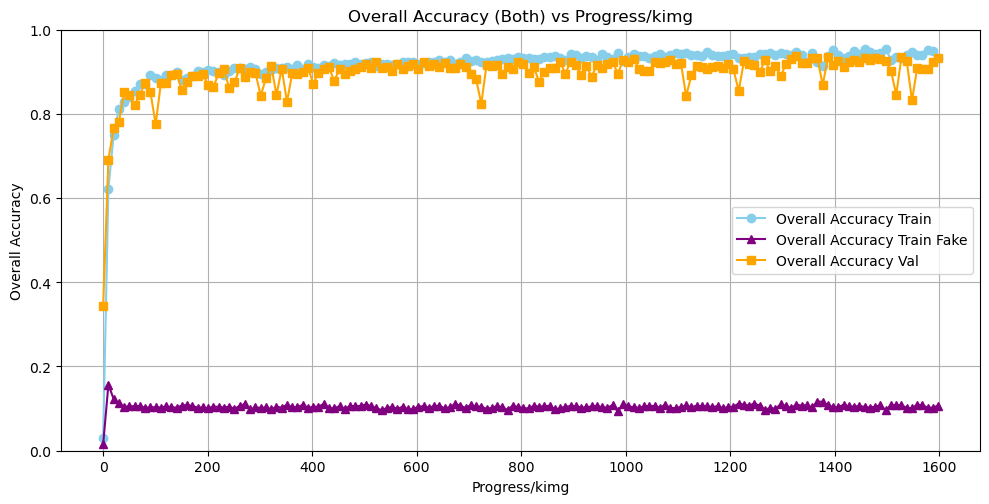

In [110]:
classification_metrics = extract_classification_metrics(jsonl_data, class_labels=class_labels)
metrics["overall_accuracy_train"], metrics["overall_accuracy_val"], metrics["overall_accuracy_train_fake"] = (
    compute_overall_accuracy(classification_metrics)
)
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=False,
    plot_type="overall",
    dataset="both",
    include_fake=True,
)

Last 10 accuracies per class (val):
Class 0: ['0.761', '0.783', '0.804', '0.870', '0.674', '0.609', '0.761', '0.696', '0.891', '0.696']
Class 1: ['0.840', '0.920', '0.920', '0.880', '0.840', '0.520', '0.800', '0.840', '0.720', '0.960']
Class 2: ['0.833', '0.889', '0.889', '0.833', '0.889', '0.722', '0.778', '0.944', '0.889', '0.944']
Class 3: ['1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '1.000', '0.857', '1.000', '1.000']
Class 4: ['0.708', '0.917', '0.875', '0.875', '0.792', '0.875', '0.833', '0.708', '0.875', '0.917']
Class 5: ['1.000', '0.600', '0.600', '0.600', '0.933', '0.933', '0.933', '0.933', '0.867', '1.000']
Class 6: ['0.913', '0.916', '0.945', '0.939', '0.649', '0.901', '0.913', '0.910', '0.904', '0.928']
Class 7: ['0.976', '0.797', '0.963', '0.939', '0.987', '0.968', '0.921', '0.887', '0.971', '0.971']
Class 8: ['0.979', '1.000', '0.979', '1.000', '1.000', '0.979', '1.000', '1.000', '1.000', '1.000']
Class 9: ['0.773', '0.773', '0.917', '0.906', '0.834', '0.928', 

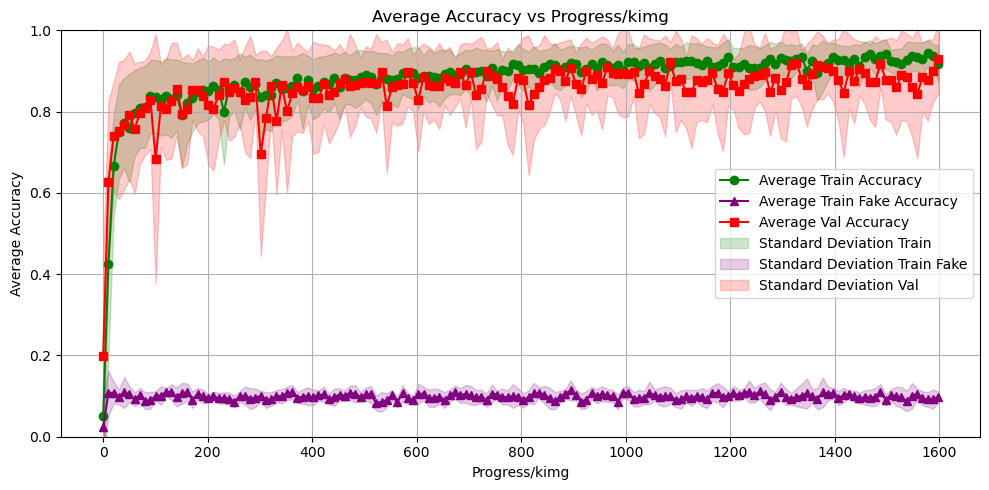

In [111]:
print_accuracies_per_class(metrics, class_labels, last_ticks=10, data_type="val")
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="average",
    dataset="both",
    include_fake=True,
)

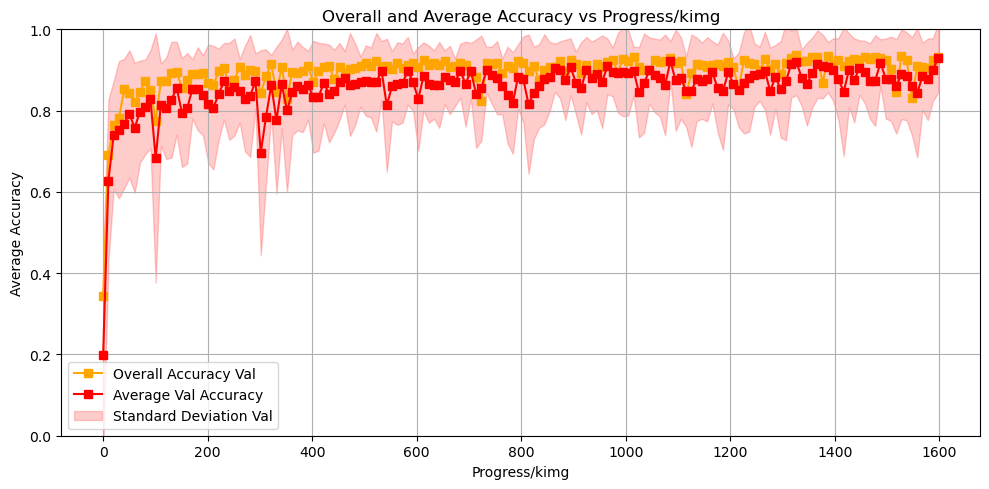

In [112]:
plot_accuracies(
    metrics,
    class_labels=class_labels,
    plot_std_in_avg_accuracy=True,
    plot_type="both",
    dataset="val",
)

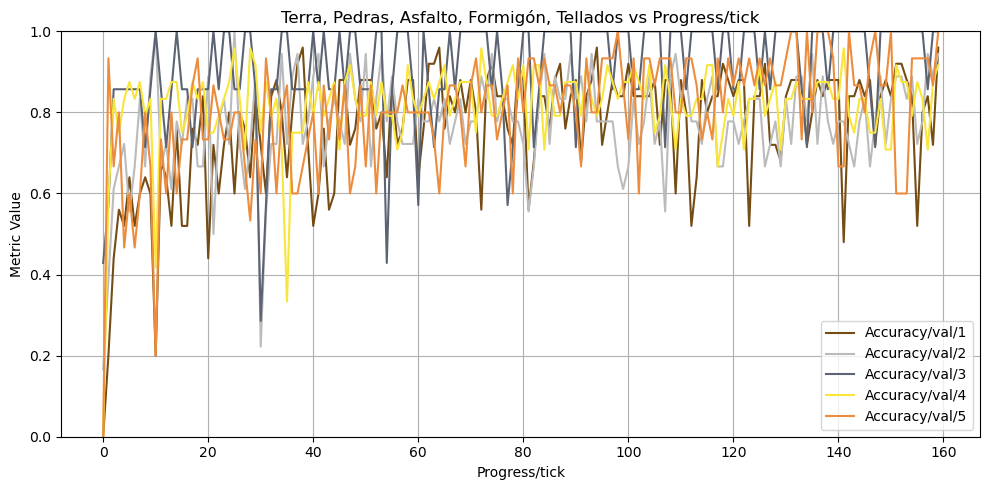

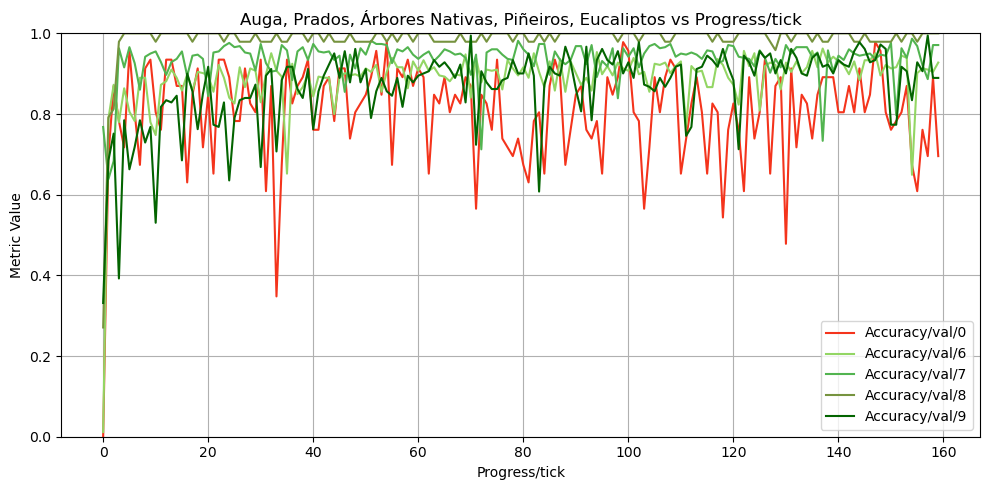

In [113]:
if "oitaven" in experiment_name:
    minority_class_labels = [1, 2, 3, 4, 5]
    colors = [class_colors[c] for c in minority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in minority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Terra, Pedras, Asfalto, Formigón, Tellados vs Progress/tick",
    )
    mayority_class_labels = [0, 6, 7, 8, 9]
    colors = [class_colors[c] for c in mayority_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in mayority_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="Auga, Prados, Árbores Nativas, Piñeiros, Eucaliptos vs Progress/tick",
    )
else:
    first_class_labels = [0, 1, 2, 3, 4]
    colors = [class_colors[c] for c in first_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in first_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="0, 1, 2, 3, 4 vs Progress/tick",
    )
    last_class_labels = [5, 6, 7, 8, 9]
    colors = [class_colors[c] for c in last_class_labels]
    plot_metric(
        metrics,
        metrics=[f"Accuracy/val/{c}" for c in last_class_labels],
        x_axis="Progress/tick",
        marker=None,
        ylim=(0, 1),
        colors=colors,
        title="5, 6, 7, 8, 9 vs Progress/tick",
    )

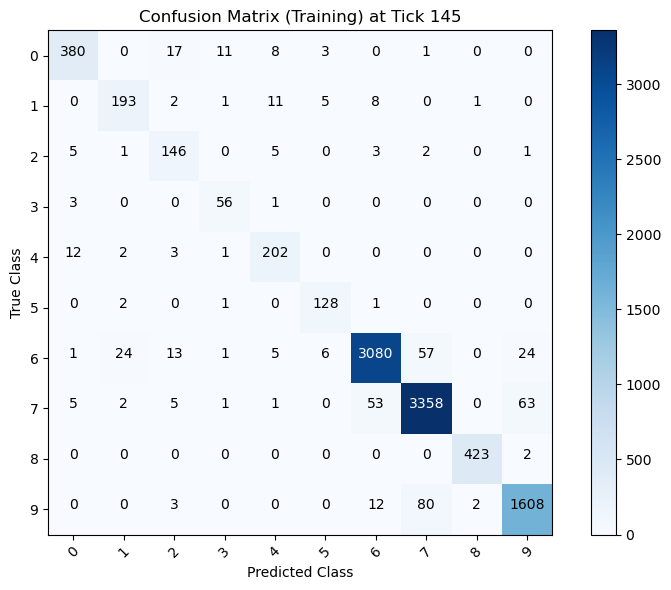

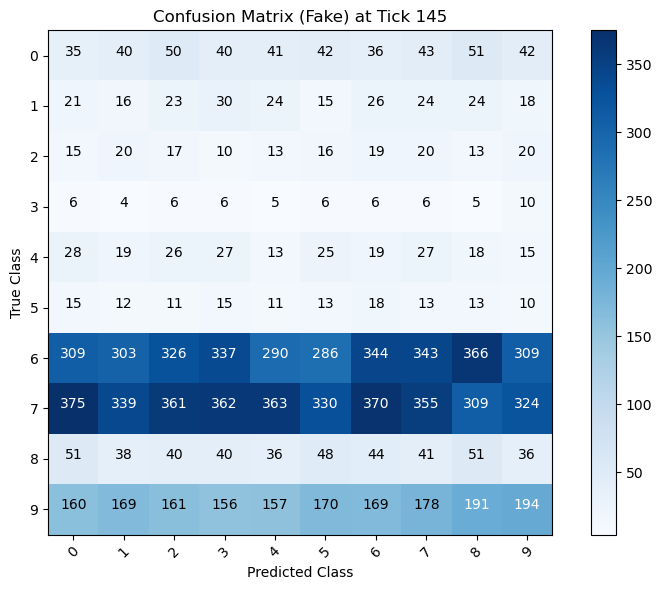

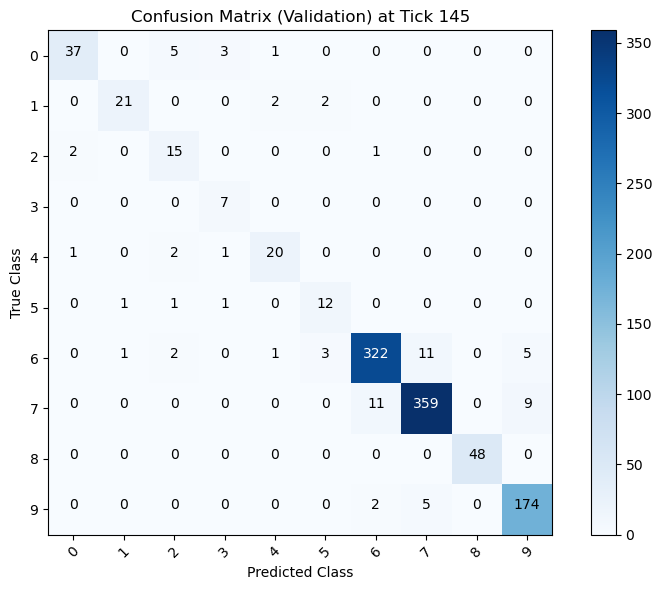

In [114]:
best_tick = int(best_tick_performance["tick"])
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="real"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Training) at Tick {best_tick}"
)
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="fake"
)
plot_confusion_matrix(confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Fake) at Tick {best_tick}")
confusion_matrix = extract_confusion_matrix(
    jsonl_data, class_labels=class_labels, progress_tick=best_tick, data_type="val"
)
plot_confusion_matrix(
    confusion_matrix, class_labels=class_labels, title=f"Confusion Matrix (Validation) at Tick {best_tick}"
)